# Entraînement aux Réseaux Antagonistes Génératifs 
## TRINCKLIN Paul
## SEVESTRE Vincent

Dans ce notebook, un modèle de GAN est créé de toutes pièces. Il est mis à exécution pour générer des images de "Pokemon". Plus de 800 images sont utilisées pour entraîner le modèle.

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import random
import scipy.misc
from utils import *
from diff import *
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, LeakyReLU, ReLU, Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Traîtement des données

### Recadrage des images (optionnel)

In [12]:
import os
import cv2

src = "./processing_data/data_raw" #imagesRGB brutes
dst = "./processing_data/resizedData" # images RGB remises à la bonne taille

os.mkdir(dst)

for each in os.listdir(src):
    img = cv2.imread(os.path.join(src,each))
    img = cv2.resize(img,(256,256))
    cv2.imwrite(os.path.join(dst,each), img)

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: './processing_data/resizedData'

### Transformation du code couleur (optionnel)

In [13]:
from PIL import Image

src = "./processing_data/resizedData"
dst = "./processing_data/resized_black/"

for each in os.listdir(src):
    png = Image.open(os.path.join(src,each))
    # print each
    if png.mode == 'RGBA':
        png.load() # required for png.split()
        background = Image.new("RGB", png.size, (0,0,0))
        background.paste(png, mask=png.split()[3]) # 3 est le canal alpha
        background.save(os.path.join(dst,each.split('.')[0] + '.jpg'), 'JPEG')
    else:
        png.convert('RGB')
        png.save(os.path.join(dst,each.split('.')[0] + '.jpg'), 'JPEG')


### Importation des images

In [14]:
src = "./data/" # imagesRGB traitées ou non 

def get_dataset(folder, image_size, batch_size):
    dataset = preprocessing.image_dataset_from_directory(
        folder, label_mode=None, image_size=(image_size, image_size), batch_size=batch_size
    )
    # Transformation des valeurs dans la plage [-1,1], car le générateur génère dans [-1,1]
    dataset = dataset.map(lambda x: (x - 127.5) / 127.5)
    return dataset

image_size = 128
batch_size = 32
dataset = get_dataset(src, image_size, batch_size)

Found 819 files belonging to 1 classes.


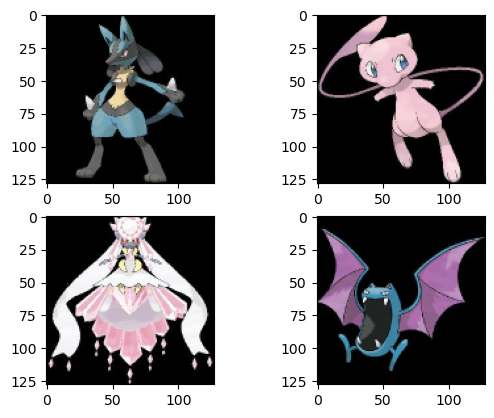

In [15]:
# Visualisation des images du dataset
for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(((batch.numpy() + 1) / 2)[i])  # Transformation des valeurs dans la plage [0,1] pour visualiser
        
    break
plt.show()

## Construction du GAN

### Générateur

Le générateur fonctione comme une sorte de réseau neuronal convolutif inverse. Un réseau neuronal convolutif typique, comme le réseau du discriminateur, transforme une matrice bidimensionnelle ou tridimensionnelle de valeurs de pixels en une probabilité unique. Un générateur, en revanche, prend un vecteur de bruit à d dimensions et le suréchantillonne pour en faire une image de 64 x 64 pixels.

D'après les recommandations sur les GAN convolutifs [1] : 
- Pour le générateur : toutes les couches auront une couche BatchNorm et une activation Relu, sauf la couche de sortie qui est une activation Tanh.
- Pour le discriminateur : toutes les couches auront une couche BatchNorm et une activation LeakyReLU, sauf la dernière couche qui est une activation Sigmoide.

In [16]:
def get_generator(latent_dim):
    """
    Crée le réseau du générateur
    """
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    generator = Sequential()

    generator.add(Input(shape=(latent_dim,)))
    # 8*8*1024
    generator.add(Dense(8 * 8 * 1024))
    generator.add(Reshape((8, 8, 1024)))

    # 8x8x1024 -> 16x16x512
    generator.add(Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 16x16x512 -> 32x32x256
    generator.add(Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 32x32x256 -> 64x64x128
    generator.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 64x64x128 -> 128x128x64
    generator.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 128x128x64 -> 128x128x3
    generator.add(Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=False, activation='tanh'))

    return generator

### Discriminateur

Le discriminateur est un réseau neuronal convolutif qui prend en entrée une image de taille 64 x 64 et renvoie un nombre scalaire unique décrivant si l'image d'entrée est "réelle" ou "fausse"

In [17]:
def get_discriminator():
    """
    Crée le réseau du discriminateur
    """
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    discriminator = Sequential()

    discriminator.add(Input(shape=(128, 128, 3)))

    # 128*128*3 -> 64*64*64
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 64x64x64 -> 32x32x128
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 32x32x128 -> 16x16x256
    discriminator.add(Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 16x16x256 -> 16x16x512
    discriminator.add(Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 16x16x512 -> 8x8x1024
    discriminator.add(Conv2D(1024, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

### Test pré-entrainement

On peut vérifier la construction du modèle en faisant une passe complète

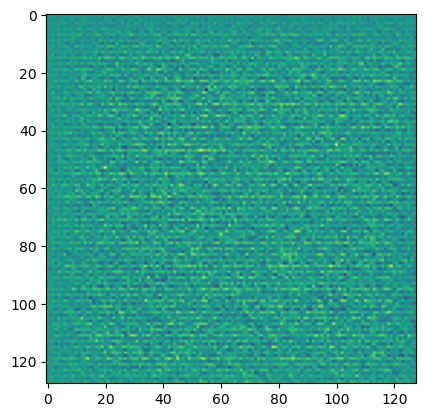

Decision: tf.Tensor([[0.5000083]], shape=(1, 1), dtype=float32)


In [18]:
latent_dim = 100
random_noise = tf.random.normal([1, latent_dim])

generator = get_generator(latent_dim)
discriminator = get_discriminator()

generated_image = generator(random_noise, training=False)
plt.imshow((generated_image[0, :, :, 0] + 1) / 2)
plt.show()

decision = discriminator(generated_image)
print("Decision:", decision)

Sans aucun entraînement, le générateur produit du bruit. Le discriminateur choisit aléatoirement un label.

### Création des pertes

Pour chaque partie du GAN, l'entropie-croisée binaire est utilisée, avec la fonction d'optimisation Adam. Cette partie d'optimisation correspond à ce qui a été fait dans le papier qui a introduit les GAN convolutifs [1].

In [19]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

def get_optimizer(lr=0.0002, beta1=0.5):
    return Adam(lr, beta1)
    
gen_optimizer = disc_optimizer = get_optimizer()
generator.compile(gen_optimizer, loss=binary_cross_entropy)
discriminator.compile(disc_optimizer, loss=binary_cross_entropy)

## Augmentation des données 

Un GAN n'est efficace qu'à partir d'un échantillon d'au moins 40 000 données. Avec 819 images, ce n'est donc pas le cas ! Pour augmenter la taille du jeu de données, une fonction auxiliaire "DiffAugment" est utilisée. Cette fonction modifie les images en les recouvrant aléatoirement d'un carré noir, en modifiant leur couleur ou en les translatant.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


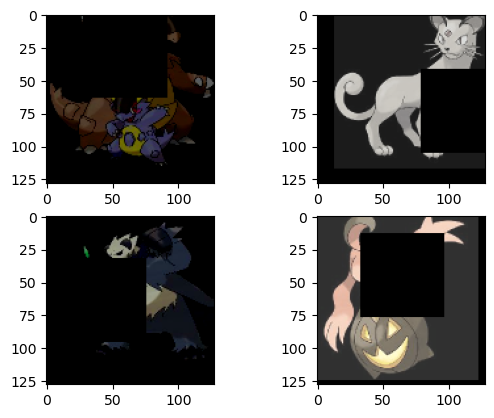

In [20]:
# Visualisation des images avec DiffAugmentation
for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow((DiffAugment((batch.numpy() + 1) / 2, policy='color,translation,cutout'))[i])
    break
plt.show()

In [21]:
def generate_and_save_images(folder, model, epoch, seed, dim=(5, 5), figsize=(5, 5)):
    """
    Effectue une passe dans le modèle et sauvegarde les images générées
    """
    generated_images = model(seed)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = preprocessing.image.array_to_img((generated_images[i] + 1 / 2))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig(folder + 'generated_image_epoch_%d.png' % epoch)
    plt.close()

### Séquence d'entraînement

Pour l'algorithme d'entraînement, une fonction bas-niveau est construite : elle représente l'entraînement du modèle à chaque itération. 3 descentes de gradient y sont réalisées : 
- 1 : Le discriminateur est entraîné à l'aide des images réelles
- 2 : Le discriminateur est entraîné à partir des images générées
- 3 : Le générateur est entraîné à partir de la classification du discriminateur

Il est important de noter que le générateur n'est jamais mis en contact avec les images réelles !

In [22]:
@tf.function
def train_step(images):
    """
    Entraîne le GAN pour une étape. Renvoie les pertes du discriminateur et du générateur
    """
    noise = tf.random.normal([batch_size, latent_dim])
    images = DiffAugment(images, policy='color,translation,cutout')

    # Descente de gradient dans le discriminateur, à partir des images réelles. Il doit donc valider ces images
    with tf.GradientTape() as disc_tape1:
        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output) * 0.9
        disc_loss1 = discriminator_loss(real_targets, real_output)

    gradients_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc1, discriminator.trainable_variables))

    # Descente de gradient dans le discriminateur, à partir des images générées. Il doit donc réfuter ces images
    with tf.GradientTape() as disc_tape2:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')

        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)

    gradients_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc2, discriminator.trainable_variables))

    # Descente de gradient dans le générateur, à partir de la classification du discriminateur
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return disc_loss1 + disc_loss2, gen_loss

Vient ensuite la fonction d'entraînement global, où s'effectuent les enregistrements des images et du modèle

In [23]:
from IPython.display import clear_output
seed = tf.random.normal([25, latent_dim])
disc_losses = []
gen_losses = []

def train(dataset, epochs):
    """
    Entraîne le GAN, et sauvegarde les images générées à chaque étape
    """

    # Epoch 0 
    generate_and_save_images("new_images/", generator, 0, seed)
    discriminator.save("models/" + "Discriminator_epoch_0")
    generator.save("models/" + "Generator_epoch_0")

    for epoch in range(epochs):
        disc_loss = gen_loss = 0
        print('Entrainement sur epoch {} (sur {}).'.format(epoch+1, epochs))
        for image_batch in tqdm(dataset):
            # Entrainement du GAN
            losses = train_step(image_batch)
            disc_loss += losses[0]
            gen_loss += losses[1]

        generate_and_save_images("new_images/", generator, epoch+1, seed)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        if epoch % 100 == 0:
            # Tous les 100 epochs, sauvegarde des poids du modèle
            
            discriminator.save("models/" + "Discriminator_epoch_%d" % epoch)
            generator.save("models/" + "Generator_epoch_%d" % epoch)

        if epoch % 10 == 0 :
            clear_output(wait=True)
        
        # Affichage des valeurs de pertes
        print("Epoch " + str(epoch + 1) + "/" +
                str(epochs) +
                " Perte générateur | Perte discriminateur : " +
                str(gen_loss.numpy()) + " | " + str(disc_loss.numpy()))

    generate_and_save_images("new_images/", generator, epochs, seed)
    discriminator.save("models/" + "Discriminator_epoch_%d" % epochs)
    generator.save("models/" + "Generator_epoch_%d" % epochs)

L'entraînement d'un GAN est très lent. Pour entraîner sur 300 épochs, il faut à peu près 12 heures.

In [ ]:
train(dataset, 300)

## Traitement des résultats

### Visualisation de l'entraînement

In [11]:
import moviepy.editor as mpy

In [12]:
# Clip gif du débruitage 
clip = mpy.ImageSequenceClip(sequence="new_images/", fps=6)
clip.write_gif('denoising_6.gif')

MoviePy - Building file denoising_6.gif with imageio.


<img src="denoising_6.gif" width="450" align="center">

### Génération par un modèle entrainé

c:\ProgramData\miniconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


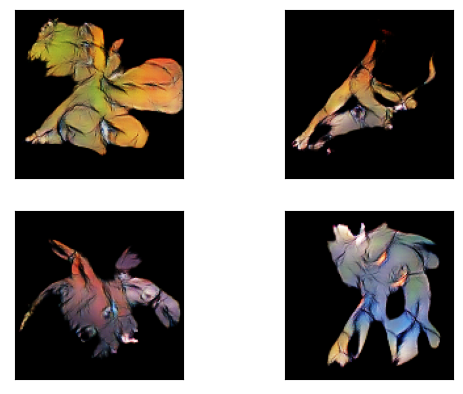

In [9]:
from keras.models import load_model

generator = load_model('models/Generator_epoch_300')
for i in range(4):
    plt.subplot(2, 2, i+1)
    random_noise = tf.random.normal([1, 100])
    generated_image = generator(random_noise, training=False)
    plt.imshow((generated_image[0] + 1) / 2)
    plt.xticks([])
    plt.yticks([])

plt.show()

## Références

[1] A. Radford, L. Metz and S. Chintala, Unsupervised representation learning with deep convolutional generative adversarial networks (2015), ICLR 2016

Images : https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset